# GraphAttentionNets

In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../data generation')
sys.path.insert(0,'../model architecture')

In [2]:
from data_generator import load_dataset
from models import *
from experiment_tools import *
from params import *

Using backend: pytorch


## Dataset
### Set hyper-parameters: dataset

In [3]:
test_cases, dataset_size, std_scaler, test_type = get_test_params()

### Select a dataset

In [13]:
idx = 0
test_case = test_cases[idx]
test_case

'pglib_opf_case24_ieee_rts.m'

### Load a dataset

In [14]:
dataset = load_dataset(test_case=test_case,
                       dataset_size=dataset_size,
                       std_scaler=std_scaler,
                       test_type=test_type,
                       gen_only=True)

FileNotFoundError: [Errno 2] No such file or directory: './../../data/size_50000/std_0.09/pglib_opf_case24_ieee_rts_gen_only_feautre.csv'

### Check the shape of the dataset
- number of samples
- number of buses
- number of generators

In [6]:
# (num_samples, num_buses),(num_samples, num_gens) 
dataset['x'].shape, dataset['y'].shape 

((50000, 24), (50000, 66))

### Check the shape of the graph

In [7]:
g = get_graph_structure(dataset['g'])

In [8]:
dataset['g'].keys()

dict_keys(['bus_idx', 'fbus2tbus', 'gen_bus_idx'])

In [9]:
dataset['g']['bus_idx'].shape, dataset['g']['fbus2tbus'].shape, dataset['g']['gen_bus_idx'].shape

((24,), (38, 2), (33, 1))

In [10]:
g

Graph(num_nodes=24, num_edges=100,
      ndata_schemes={}
      edata_schemes={})

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

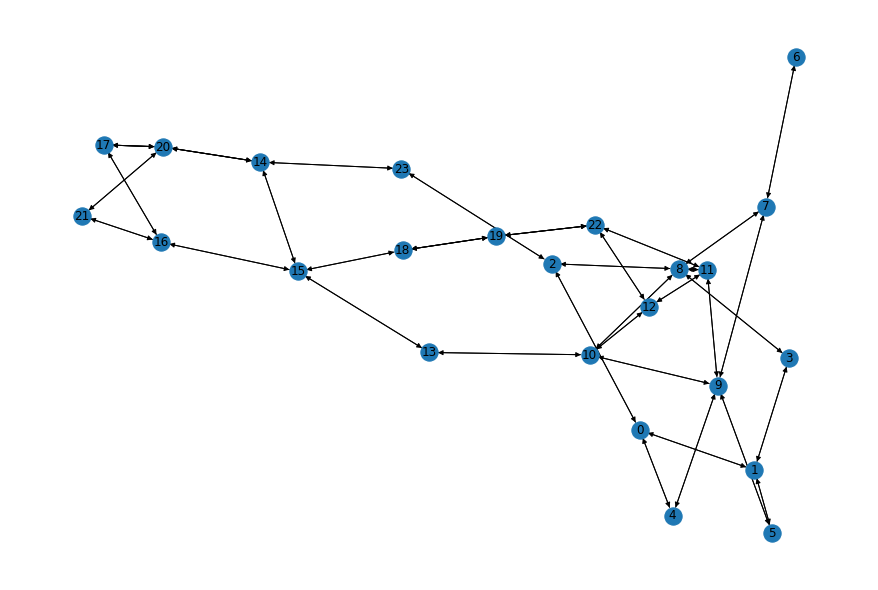

In [12]:
nx.draw(g.to_networkx(), with_labels=True)
plt.show()

## Model
### Set hyper-parameters: model

In [20]:
class GraphAttentionNet(nn.Module):
    def __init__(self, in_feats, out_feats, num_heads):
        super(GraphAttentionNet, self).__init__()
        self.gat_1 = GATConv(in_feats, 100, num_heads)
        self.gat_2 = GATConv(100 * num_heads, 200, num_heads)
        self.gat_3 = GATConv(200 * num_heads, out_feats, 1)
        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, x):
        x = self.gat_1(g, x)
        x = self.elu(x)
        print(x.size())
        x = self.gat_2(g, x)
        x = self.elu(x)
        print(x.size())
        x = self.gat_3(g, x)
        x = self.sigmoid(x)
        print(x.size())
        return x

In [ ]:
model_name = "gat"
num_epochs, batch_size, lr = get_h_params(model_name)

### Set data-loaders

In [ ]:
train_loader, val_loader, test_loader = data_prep(dataset=dataset,
                                                  batch_size=batch_size)

### Check the shape of the data-loaders
- number of batch
- number of buses
- number of generators

In [ ]:
feature, label = next(iter(train_loader))
feature.shape, label.shape

In [ ]:
feature, label = next(iter(val_loader))
feature.shape, label.shape

In [ ]:
feature, label = next(iter(test_loader))
feature.shape, label.shape

### Set a model

In [25]:
gat = GraphAttentionNet(dataset['x'].shape[1],
                        dataset['y'].shape[1],
                        num_heads=3)

# ???
loss_func = nn.BCELoss()
# loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(gat.parameters(), lr=lr, momentum=0.9)

gat.eval()

GraphAttentionNet(
  (gat_1): GATConv(
    (fc): Linear(in_features=24, out_features=300, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (gat_2): GATConv(
    (fc): Linear(in_features=300, out_features=600, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (gat_3): GATConv(
    (fc): Linear(in_features=600, out_features=142, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (elu): ELU(alpha=1.0)
  (sigmoid): Sigmoid()
)

### Train the model

In [24]:
train(net=gat,
      train_loader=train_loader,
      val_loader=val_loader,
      optimizer=optimizer,
      loss_func=loss_func,
      model_name=model_name,
      dataset_name=test_case,
      g=g,
      num_epochs=num_epochs)

> case: pglib_opf_case24_ieee_rts
> model: gat
- num of params: 274484
- training


DGLError: Expect number of features to match number of nodes (len(u)). Got 1 and 24 instead.

### Test the model

In [15]:
test(net=gat,
     test_loader=test_loader,
     model_name="gat",
     dataset_name=test_case,
     g=g)

- testing
	accuracy: 71.18576284743051%
